# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

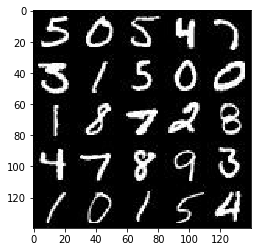

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

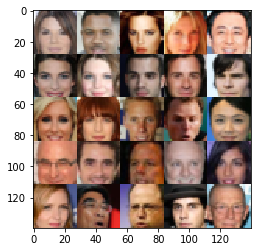

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [5]:
# Some fallbacks for old versions of tensorflow (1.3 on AWS)
try:
    leaky_relu = tf.nn.leaky_relu
except AttributeError:
    warnings.warn('Using fallback leaky_relu')
    def leaky_relu(inputs, alpha=0.2):
        return tf.maximum(inputs, inputs * alpha)
    

try:
    flatten = tf.layers.flatten
except AttributeError:
    warnings.warn('Using fallback flatten')
    import functools
    import operator
    
    def flatten(inputs):
        shape = inputs.get_shape()
        target_dim = functools.reduce(operator.mul, map(int, shape[1:]))
        return tf.reshape(inputs, [-1, target_dim])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: UserWarning: Using fallback leaky_relu
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: UserWarning: Using fallback flatten
  del sys.path[0]


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_inputs = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_inputs')
    random_inputs = tf.placeholder(tf.float32, shape=[None, z_dim], name='random_inputs')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_inputs, random_inputs, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [21]:
KERNEL_SIZE = 5
STRIDES = 2


def conv2d(
    inputs, filters, is_training,
    normalization=True, activation=True, kernel_size=KERNEL_SIZE,
    dropout=True
):
    output = tf.layers.conv2d(
        inputs=inputs, filters=filters,
        kernel_size=kernel_size, strides=STRIDES, padding='same',
        use_bias=not normalization,
        kernel_initializer=tf.contrib.layers.xavier_initializer()
    )
    if normalization:
        output = tf.layers.batch_normalization(output, training=is_training)
    if activation:
        output = leaky_relu(output)
    if dropout:
        output = dropout_layer(output)
    return output
    
    
def dense(inputs, units, is_training, normalization=True, activation=True, dropout=False):
    output = tf.layers.dense(
        inputs=inputs, units=units, use_bias=not normalization,
        kernel_initializer=tf.contrib.layers.xavier_initializer()
    )
    if normalization:
        output = tf.layers.batch_normalization(output, training=is_training)
    if activation:
        output = leaky_relu(output)
    if dropout:
        output = dropout_layer(output)
    return output


dropout_layer = functools.partial(tf.nn.dropout, keep_prob=0.9)
    
    
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    is_training = True
    with tf.variable_scope('discriminator', reuse=reuse):
        output = images
        # Shape 28x28xchannels
        output = conv2d(output, 128, is_training, normalization=False, dropout=False)
        # Shape is 14x14
        output = conv2d(output, 256, is_training)
        # Shape 7x7
        output = conv2d(output, 512, is_training)
        # Shape 4x4
        output = flatten(output)
        # Shape 4*4*512 = 8K
        
        output = dense(output, 512, is_training, dropout=True)
        
        logits = dense(output, 1, is_training, normalization=False, activation=False)
        output = tf.nn.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def conv2d_transpose(
    inputs, filters, is_training,
    normalization=True, activation=True, kernel_size=KERNEL_SIZE
):
    output = tf.layers.conv2d_transpose(
        inputs, filters=filters,
        kernel_size=kernel_size, strides=STRIDES, padding='same',
        use_bias=not normalization,
        kernel_initializer=tf.contrib.layers.xavier_initializer()
    )
    if normalization:
        output = tf.layers.batch_normalization(output, training=is_training)
    if activation:
        output = leaky_relu(output)
    return output


def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        output = dense(z, 4 * 4 * 512, is_train)
        output = tf.reshape(output, [-1, 4, 4, 512])
        
        # Shape is 4x4
        output = conv2d_transpose(output, 256, is_train)
        # Shape is 8x8
        output = conv2d_transpose(output, 128, is_train)
        # Shape ix 16x16
        output = conv2d_transpose(
            output, out_channel_dim, is_train,
            normalization=False, activation=False
        )
        # Shape is 32x32xout_channel_dim
        output = tf.tanh(output)
        # Cut the the center of the generated image
        output = tf.image.crop_to_bounding_box(output, 2, 2, 28, 28)
        # Shape is 28x28xout_channel_dim
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    generator_model = generator(input_z, out_channel_dim, is_train=True)
    discriminator_model_real, discriminator_logits_real = discriminator(
        input_real, reuse=False
    )
    discriminator_model_fake, discriminator_logits_fake = discriminator(
        generator_model, reuse=True
    )
    discriminator_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_real, labels=tf.ones_like(discriminator_logits_real)
    ))
    discriminator_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_fake, labels=tf.zeros_like(discriminator_logits_fake)
    ))
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=discriminator_logits_fake, labels=tf.ones_like(discriminator_logits_fake)
    ))
    discriminator_loss = discriminator_real_loss + discriminator_fake_loss
    
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainable_vars = tf.trainable_variables()
    discriminator_variables = [var for var in trainable_vars if var.name.startswith('discriminator')]
    generator_variables = [var for var in trainable_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate, beta1=beta1
        ).minimize(
            d_loss, var_list=discriminator_variables
        )
        generator_optimizer = tf.train.AdamOptimizer(
            learning_rate=learning_rate, beta1=beta1
        ).minimize(
            g_loss, var_list=generator_variables
        )
    
    return discriminator_optimizer, generator_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [39]:
PRINT_EVERY = 20
VIEW_EVERY = PRINT_EVERY * 5

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    number_of_examples, *_, out_channel_dim = data_shape
    (
        real_images, z, learning_rate_tensor
    ) = model_inputs(*data_shape[1:], z_dim)
    batches_per_epoch = int(number_of_examples / batch_size)
    
    discriminator_loss, generator_loss = model_loss(
        real_images, z, out_channel_dim
    )
    discriminator_opt, generator_opt = model_opt(
        discriminator_loss, generator_loss, learning_rate_tensor, beta1
    )
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        show_output = functools.partial(
            show_generator_output, 
            sess, 16, z, out_channel_dim, data_image_mode
        )
        step = 0
        # Show the initial white noise
        show_output()
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                feed_dict = {
                    real_images: batch_images * 2,
                    z: batch_z,
                    learning_rate_tensor: learning_rate,
                }
                sess.run(discriminator_opt, feed_dict=feed_dict)
                sess.run(generator_opt, feed_dict=feed_dict)
                step += 1
                if step % PRINT_EVERY == 0:
                    train_loss_discriminator = discriminator_loss.eval(feed_dict)
                    train_loss_generator = generator_loss.eval(feed_dict)
                    print(
                        'Epoch {epoch_i}/{epoch_count} '
                        'Step {step}/{steps}: '
                        'Discriminator Loss: {train_loss_discriminator:.4f}. '
                        'Generator Loss: {train_loss_generator:.4f}'.format(
                            epoch_i=epoch_i + 1,
                            epoch_count=epoch_count,
                            step=step,
                            steps=batches_per_epoch * epoch_count,
                            train_loss_generator=train_loss_generator,
                            train_loss_discriminator=train_loss_discriminator
                        )
                    )
                if step % VIEW_EVERY == 0:
                    show_output()
                    
        # Show final result
        show_output()

##### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

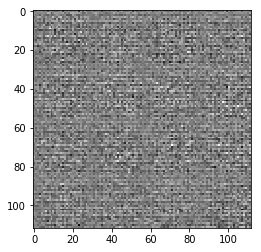

Epoch 1/2 Step 10/1874: Discriminator Loss: 1.7750. Generator Loss: 1.1607
Epoch 1/2 Step 20/1874: Discriminator Loss: 1.4652. Generator Loss: 0.8709
Epoch 1/2 Step 30/1874: Discriminator Loss: 1.3679. Generator Loss: 0.8427


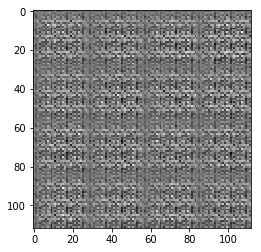

Epoch 1/2 Step 40/1874: Discriminator Loss: 1.3494. Generator Loss: 0.8336
Epoch 1/2 Step 50/1874: Discriminator Loss: 1.2678. Generator Loss: 0.8582
Epoch 1/2 Step 60/1874: Discriminator Loss: 1.2885. Generator Loss: 0.8306


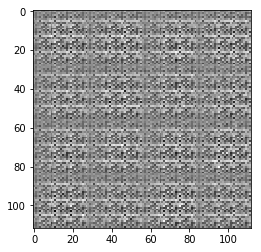

Epoch 1/2 Step 70/1874: Discriminator Loss: 1.1512. Generator Loss: 0.8690
Epoch 1/2 Step 80/1874: Discriminator Loss: 1.0993. Generator Loss: 0.9182
Epoch 1/2 Step 90/1874: Discriminator Loss: 1.1053. Generator Loss: 0.9630


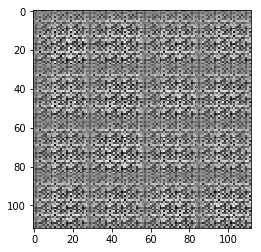

Epoch 1/2 Step 100/1874: Discriminator Loss: 1.1989. Generator Loss: 0.9958
Epoch 1/2 Step 110/1874: Discriminator Loss: 1.0014. Generator Loss: 1.0125
Epoch 1/2 Step 120/1874: Discriminator Loss: 1.0784. Generator Loss: 1.0466


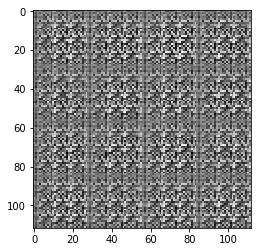

Epoch 1/2 Step 130/1874: Discriminator Loss: 0.9981. Generator Loss: 1.0107
Epoch 1/2 Step 140/1874: Discriminator Loss: 0.9393. Generator Loss: 1.0669
Epoch 1/2 Step 150/1874: Discriminator Loss: 1.0086. Generator Loss: 1.1325


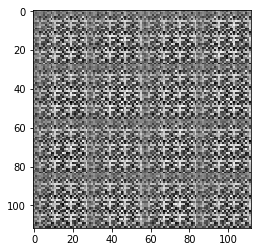

Epoch 1/2 Step 160/1874: Discriminator Loss: 0.9377. Generator Loss: 1.1251
Epoch 1/2 Step 170/1874: Discriminator Loss: 0.9961. Generator Loss: 1.2087
Epoch 1/2 Step 180/1874: Discriminator Loss: 0.8841. Generator Loss: 1.2018


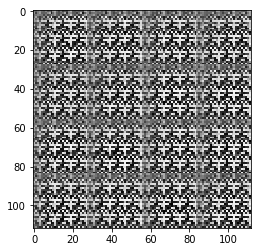

Epoch 1/2 Step 190/1874: Discriminator Loss: 0.7318. Generator Loss: 1.2392
Epoch 1/2 Step 200/1874: Discriminator Loss: 0.8409. Generator Loss: 1.2900
Epoch 1/2 Step 210/1874: Discriminator Loss: 0.8014. Generator Loss: 1.2916


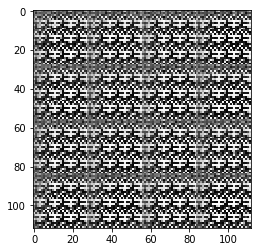

Epoch 1/2 Step 220/1874: Discriminator Loss: 0.8158. Generator Loss: 1.3399
Epoch 1/2 Step 230/1874: Discriminator Loss: 0.7817. Generator Loss: 1.3200
Epoch 1/2 Step 240/1874: Discriminator Loss: 0.7246. Generator Loss: 1.4328


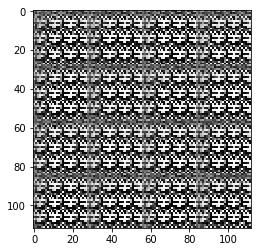

Epoch 1/2 Step 250/1874: Discriminator Loss: 0.6982. Generator Loss: 1.4343
Epoch 1/2 Step 260/1874: Discriminator Loss: 0.7435. Generator Loss: 1.4302
Epoch 1/2 Step 270/1874: Discriminator Loss: 0.7230. Generator Loss: 1.4154


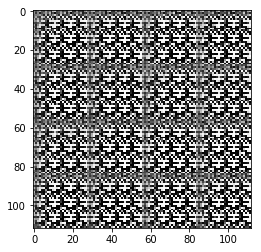

Epoch 1/2 Step 280/1874: Discriminator Loss: 0.5973. Generator Loss: 1.5640
Epoch 1/2 Step 290/1874: Discriminator Loss: 0.6376. Generator Loss: 1.5136
Epoch 1/2 Step 300/1874: Discriminator Loss: 0.6064. Generator Loss: 1.5791


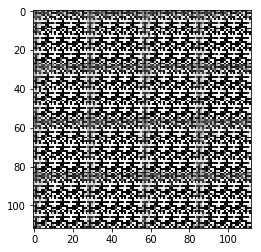

Epoch 1/2 Step 310/1874: Discriminator Loss: 0.6104. Generator Loss: 1.4643
Epoch 1/2 Step 320/1874: Discriminator Loss: 0.6579. Generator Loss: 1.4992
Epoch 1/2 Step 330/1874: Discriminator Loss: 0.6204. Generator Loss: 1.6272


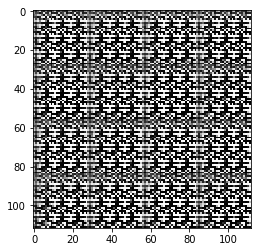

Epoch 1/2 Step 340/1874: Discriminator Loss: 0.5593. Generator Loss: 1.6226
Epoch 1/2 Step 350/1874: Discriminator Loss: 0.5235. Generator Loss: 1.7077
Epoch 1/2 Step 360/1874: Discriminator Loss: 0.4869. Generator Loss: 1.8353


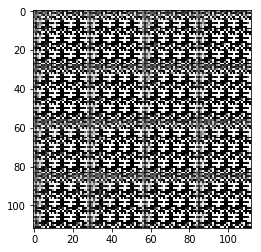

Epoch 1/2 Step 370/1874: Discriminator Loss: 2.0057. Generator Loss: 1.7023
Epoch 1/2 Step 380/1874: Discriminator Loss: 0.5093. Generator Loss: 1.6547
Epoch 1/2 Step 390/1874: Discriminator Loss: 0.5329. Generator Loss: 1.7722


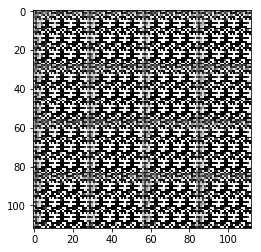

Epoch 1/2 Step 400/1874: Discriminator Loss: 0.4541. Generator Loss: 1.7933
Epoch 1/2 Step 410/1874: Discriminator Loss: 0.4546. Generator Loss: 1.9175
Epoch 1/2 Step 420/1874: Discriminator Loss: 0.4449. Generator Loss: 1.8326


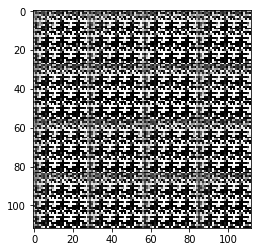

Epoch 1/2 Step 430/1874: Discriminator Loss: 0.3959. Generator Loss: 1.9853
Epoch 1/2 Step 440/1874: Discriminator Loss: 0.5204. Generator Loss: 1.8128
Epoch 1/2 Step 450/1874: Discriminator Loss: 0.3668. Generator Loss: 1.9122


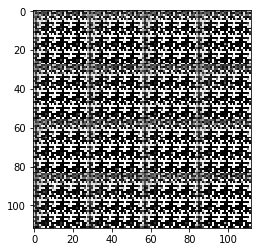

Epoch 1/2 Step 460/1874: Discriminator Loss: 0.4470. Generator Loss: 1.8701
Epoch 1/2 Step 470/1874: Discriminator Loss: 0.5150. Generator Loss: 1.8798
Epoch 1/2 Step 480/1874: Discriminator Loss: 0.3658. Generator Loss: 2.0321


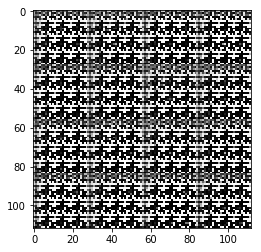

Epoch 1/2 Step 490/1874: Discriminator Loss: 0.4210. Generator Loss: 2.1657
Epoch 1/2 Step 500/1874: Discriminator Loss: 0.5042. Generator Loss: 2.0543
Epoch 1/2 Step 510/1874: Discriminator Loss: 0.3741. Generator Loss: 2.0481


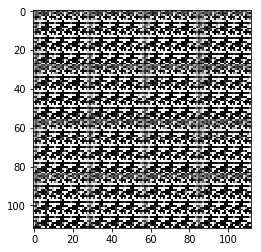

Epoch 1/2 Step 520/1874: Discriminator Loss: 0.3699. Generator Loss: 2.1156
Epoch 1/2 Step 530/1874: Discriminator Loss: 0.3403. Generator Loss: 2.0252
Epoch 1/2 Step 540/1874: Discriminator Loss: 0.3344. Generator Loss: 2.1239


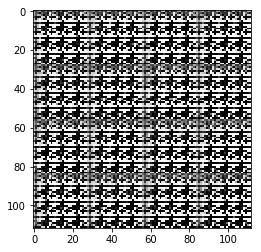

Epoch 1/2 Step 550/1874: Discriminator Loss: 0.3972. Generator Loss: 2.1562
Epoch 1/2 Step 560/1874: Discriminator Loss: 0.2827. Generator Loss: 2.1700
Epoch 1/2 Step 570/1874: Discriminator Loss: 0.2731. Generator Loss: 2.1982


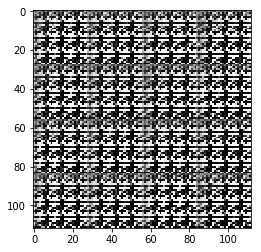

Epoch 1/2 Step 580/1874: Discriminator Loss: 0.3690. Generator Loss: 2.0771
Epoch 1/2 Step 590/1874: Discriminator Loss: 0.5397. Generator Loss: 2.0558
Epoch 1/2 Step 600/1874: Discriminator Loss: 0.2504. Generator Loss: 2.1098


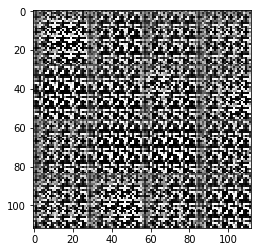

Epoch 1/2 Step 610/1874: Discriminator Loss: 0.3686. Generator Loss: 1.8293
Epoch 1/2 Step 620/1874: Discriminator Loss: 0.3854. Generator Loss: 1.9740
Epoch 1/2 Step 630/1874: Discriminator Loss: 0.2559. Generator Loss: 1.9604


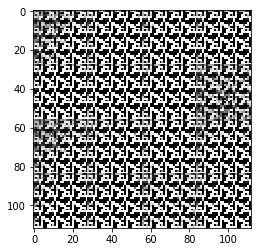

Epoch 1/2 Step 640/1874: Discriminator Loss: 0.1633. Generator Loss: 2.6509
Epoch 1/2 Step 650/1874: Discriminator Loss: 0.3595. Generator Loss: 2.2286
Epoch 1/2 Step 660/1874: Discriminator Loss: 0.4730. Generator Loss: 2.4272


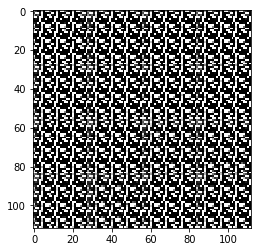

Epoch 1/2 Step 670/1874: Discriminator Loss: 0.8267. Generator Loss: 1.9380
Epoch 1/2 Step 680/1874: Discriminator Loss: 0.6111. Generator Loss: 1.7323
Epoch 1/2 Step 690/1874: Discriminator Loss: 0.7141. Generator Loss: 1.4779


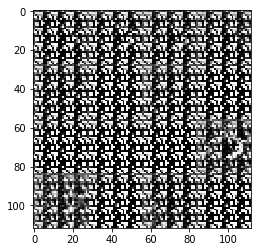

Epoch 1/2 Step 700/1874: Discriminator Loss: 0.4752. Generator Loss: 2.0251
Epoch 1/2 Step 710/1874: Discriminator Loss: 0.8997. Generator Loss: 1.3890
Epoch 1/2 Step 720/1874: Discriminator Loss: 0.7622. Generator Loss: 0.9660


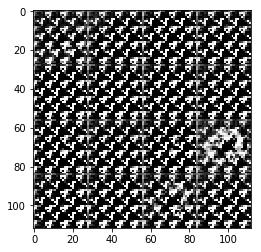

Epoch 1/2 Step 730/1874: Discriminator Loss: 0.4830. Generator Loss: 1.5799
Epoch 1/2 Step 740/1874: Discriminator Loss: 0.4966. Generator Loss: 1.5571
Epoch 1/2 Step 750/1874: Discriminator Loss: 1.2219. Generator Loss: 1.4890


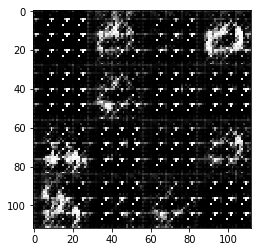

Epoch 1/2 Step 760/1874: Discriminator Loss: 0.6464. Generator Loss: 1.2079
Epoch 1/2 Step 770/1874: Discriminator Loss: 0.7975. Generator Loss: 1.2842
Epoch 1/2 Step 780/1874: Discriminator Loss: 0.5240. Generator Loss: 1.2314


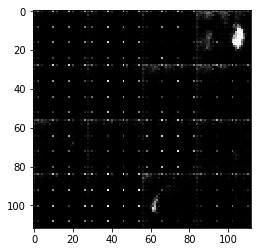

Epoch 1/2 Step 790/1874: Discriminator Loss: 0.4582. Generator Loss: 1.4591
Epoch 1/2 Step 800/1874: Discriminator Loss: 0.8176. Generator Loss: 0.8621
Epoch 1/2 Step 810/1874: Discriminator Loss: 0.9065. Generator Loss: 1.6293


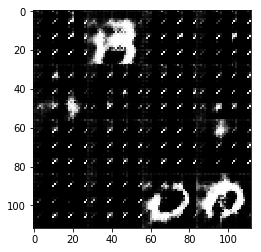

Epoch 1/2 Step 820/1874: Discriminator Loss: 0.6068. Generator Loss: 1.8407
Epoch 1/2 Step 830/1874: Discriminator Loss: 0.7011. Generator Loss: 1.4700
Epoch 1/2 Step 840/1874: Discriminator Loss: 0.7749. Generator Loss: 1.2351


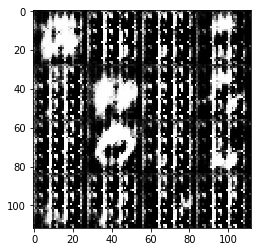

Epoch 1/2 Step 850/1874: Discriminator Loss: 1.1335. Generator Loss: 1.2538
Epoch 1/2 Step 860/1874: Discriminator Loss: 1.0335. Generator Loss: 1.0624
Epoch 1/2 Step 870/1874: Discriminator Loss: 0.9289. Generator Loss: 0.9941


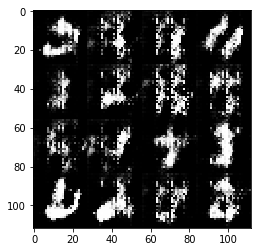

Epoch 1/2 Step 880/1874: Discriminator Loss: 0.7658. Generator Loss: 1.0768
Epoch 1/2 Step 890/1874: Discriminator Loss: 1.1482. Generator Loss: 0.9321
Epoch 1/2 Step 900/1874: Discriminator Loss: 1.3274. Generator Loss: 0.8194


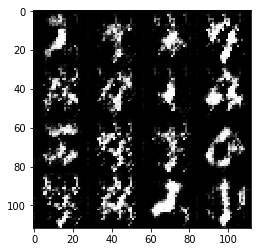

Epoch 1/2 Step 910/1874: Discriminator Loss: 1.3440. Generator Loss: 0.8626
Epoch 1/2 Step 920/1874: Discriminator Loss: 1.2876. Generator Loss: 0.9973
Epoch 1/2 Step 930/1874: Discriminator Loss: 0.9837. Generator Loss: 0.8724


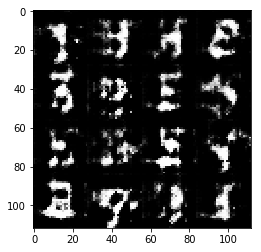

Epoch 2/2 Step 940/1874: Discriminator Loss: 1.0981. Generator Loss: 0.6892
Epoch 2/2 Step 950/1874: Discriminator Loss: 1.3143. Generator Loss: 0.7581
Epoch 2/2 Step 960/1874: Discriminator Loss: 1.2912. Generator Loss: 0.6412


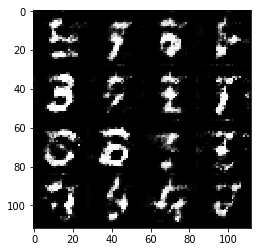

Epoch 2/2 Step 970/1874: Discriminator Loss: 1.0601. Generator Loss: 0.8405
Epoch 2/2 Step 980/1874: Discriminator Loss: 1.1733. Generator Loss: 0.8367
Epoch 2/2 Step 990/1874: Discriminator Loss: 0.8432. Generator Loss: 0.8726


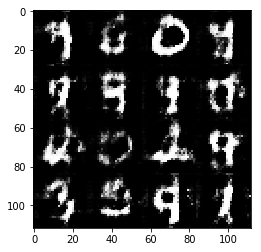

Epoch 2/2 Step 1000/1874: Discriminator Loss: 1.1236. Generator Loss: 0.7302
Epoch 2/2 Step 1010/1874: Discriminator Loss: 1.3122. Generator Loss: 0.9547
Epoch 2/2 Step 1020/1874: Discriminator Loss: 1.0753. Generator Loss: 0.8418


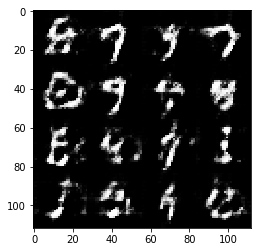

Epoch 2/2 Step 1030/1874: Discriminator Loss: 1.1257. Generator Loss: 0.9213
Epoch 2/2 Step 1040/1874: Discriminator Loss: 1.1202. Generator Loss: 0.8148
Epoch 2/2 Step 1050/1874: Discriminator Loss: 1.1785. Generator Loss: 0.9504


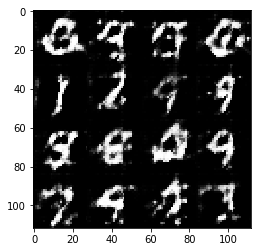

Epoch 2/2 Step 1060/1874: Discriminator Loss: 1.2475. Generator Loss: 0.8801
Epoch 2/2 Step 1070/1874: Discriminator Loss: 1.0544. Generator Loss: 1.0982
Epoch 2/2 Step 1080/1874: Discriminator Loss: 1.2134. Generator Loss: 0.7601


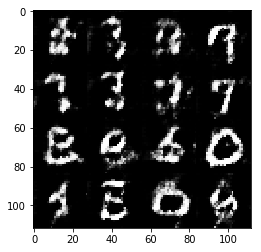

Epoch 2/2 Step 1090/1874: Discriminator Loss: 1.1151. Generator Loss: 0.7956
Epoch 2/2 Step 1100/1874: Discriminator Loss: 1.1615. Generator Loss: 0.8851
Epoch 2/2 Step 1110/1874: Discriminator Loss: 1.1202. Generator Loss: 0.9019


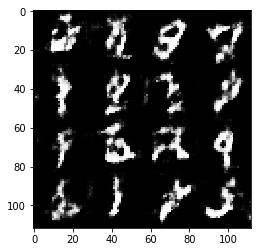

Epoch 2/2 Step 1120/1874: Discriminator Loss: 1.0813. Generator Loss: 0.8083
Epoch 2/2 Step 1130/1874: Discriminator Loss: 1.0161. Generator Loss: 1.0202
Epoch 2/2 Step 1140/1874: Discriminator Loss: 1.0311. Generator Loss: 0.8256


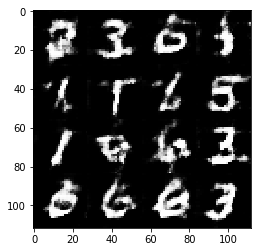

Epoch 2/2 Step 1150/1874: Discriminator Loss: 0.9897. Generator Loss: 0.8898
Epoch 2/2 Step 1160/1874: Discriminator Loss: 1.1798. Generator Loss: 0.7114
Epoch 2/2 Step 1170/1874: Discriminator Loss: 1.1150. Generator Loss: 0.8378


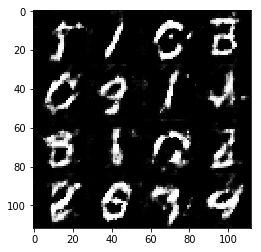

Epoch 2/2 Step 1180/1874: Discriminator Loss: 0.9254. Generator Loss: 1.0387
Epoch 2/2 Step 1190/1874: Discriminator Loss: 0.9719. Generator Loss: 1.0411
Epoch 2/2 Step 1200/1874: Discriminator Loss: 1.0485. Generator Loss: 0.9297


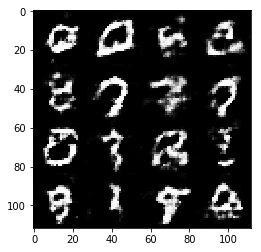

Epoch 2/2 Step 1210/1874: Discriminator Loss: 1.1717. Generator Loss: 0.8571
Epoch 2/2 Step 1220/1874: Discriminator Loss: 1.1771. Generator Loss: 0.8352
Epoch 2/2 Step 1230/1874: Discriminator Loss: 1.0101. Generator Loss: 1.0602


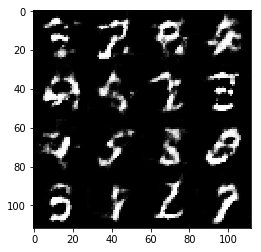

Epoch 2/2 Step 1240/1874: Discriminator Loss: 0.9989. Generator Loss: 1.1469
Epoch 2/2 Step 1250/1874: Discriminator Loss: 1.1053. Generator Loss: 0.9002
Epoch 2/2 Step 1260/1874: Discriminator Loss: 1.0503. Generator Loss: 0.9211


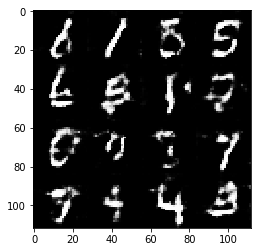

Epoch 2/2 Step 1270/1874: Discriminator Loss: 1.0369. Generator Loss: 1.0761
Epoch 2/2 Step 1280/1874: Discriminator Loss: 1.0707. Generator Loss: 0.7822
Epoch 2/2 Step 1290/1874: Discriminator Loss: 0.8420. Generator Loss: 1.0148


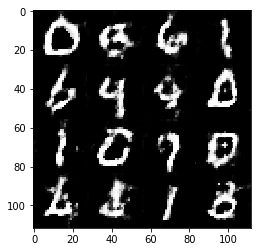

Epoch 2/2 Step 1300/1874: Discriminator Loss: 1.1211. Generator Loss: 0.9988
Epoch 2/2 Step 1310/1874: Discriminator Loss: 1.2607. Generator Loss: 1.0170
Epoch 2/2 Step 1320/1874: Discriminator Loss: 1.3739. Generator Loss: 0.8630


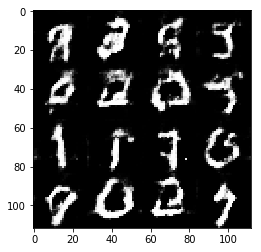

Epoch 2/2 Step 1330/1874: Discriminator Loss: 0.8738. Generator Loss: 1.1442
Epoch 2/2 Step 1340/1874: Discriminator Loss: 0.7969. Generator Loss: 1.1795
Epoch 2/2 Step 1350/1874: Discriminator Loss: 0.8036. Generator Loss: 1.0441


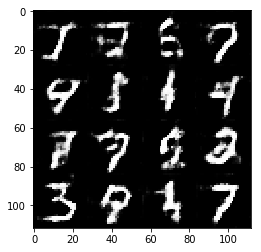

Epoch 2/2 Step 1360/1874: Discriminator Loss: 1.0450. Generator Loss: 0.7875
Epoch 2/2 Step 1370/1874: Discriminator Loss: 0.7823. Generator Loss: 1.2655
Epoch 2/2 Step 1380/1874: Discriminator Loss: 0.7828. Generator Loss: 1.1458


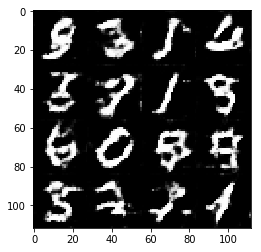

Epoch 2/2 Step 1390/1874: Discriminator Loss: 0.8292. Generator Loss: 1.0127
Epoch 2/2 Step 1400/1874: Discriminator Loss: 1.0546. Generator Loss: 1.1242
Epoch 2/2 Step 1410/1874: Discriminator Loss: 0.9780. Generator Loss: 0.9772


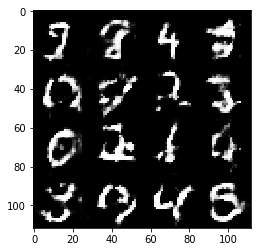

Epoch 2/2 Step 1420/1874: Discriminator Loss: 1.0298. Generator Loss: 0.7040
Epoch 2/2 Step 1430/1874: Discriminator Loss: 1.0362. Generator Loss: 0.9188
Epoch 2/2 Step 1440/1874: Discriminator Loss: 0.6611. Generator Loss: 1.2860


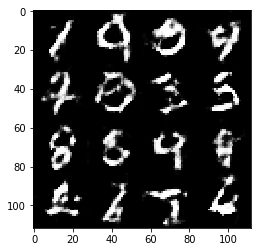

Epoch 2/2 Step 1450/1874: Discriminator Loss: 0.8915. Generator Loss: 1.0843
Epoch 2/2 Step 1460/1874: Discriminator Loss: 0.9473. Generator Loss: 0.6606
Epoch 2/2 Step 1470/1874: Discriminator Loss: 1.2555. Generator Loss: 0.8152


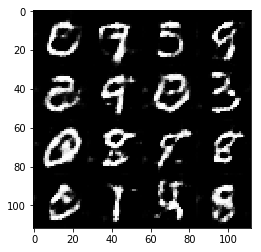

Epoch 2/2 Step 1480/1874: Discriminator Loss: 1.1203. Generator Loss: 0.9503
Epoch 2/2 Step 1490/1874: Discriminator Loss: 0.8129. Generator Loss: 1.0426
Epoch 2/2 Step 1500/1874: Discriminator Loss: 0.9312. Generator Loss: 0.9117


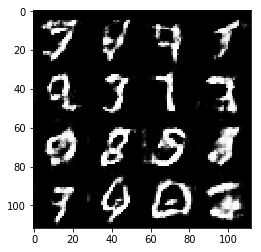

Epoch 2/2 Step 1510/1874: Discriminator Loss: 0.8121. Generator Loss: 1.0045
Epoch 2/2 Step 1520/1874: Discriminator Loss: 2.6441. Generator Loss: 1.6632
Epoch 2/2 Step 1530/1874: Discriminator Loss: 0.8243. Generator Loss: 1.1266


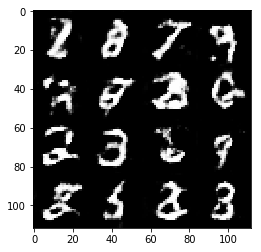

Epoch 2/2 Step 1540/1874: Discriminator Loss: 0.8150. Generator Loss: 1.0717
Epoch 2/2 Step 1550/1874: Discriminator Loss: 0.9229. Generator Loss: 0.9603
Epoch 2/2 Step 1560/1874: Discriminator Loss: 0.7157. Generator Loss: 1.1346


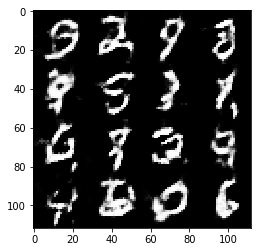

Epoch 2/2 Step 1570/1874: Discriminator Loss: 0.6566. Generator Loss: 1.0756
Epoch 2/2 Step 1580/1874: Discriminator Loss: 0.6282. Generator Loss: 1.0907
Epoch 2/2 Step 1590/1874: Discriminator Loss: 1.0520. Generator Loss: 0.9331


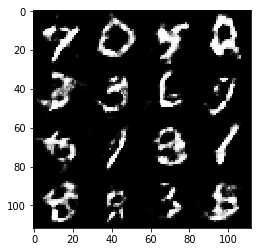

Epoch 2/2 Step 1600/1874: Discriminator Loss: 0.9008. Generator Loss: 0.8832
Epoch 2/2 Step 1610/1874: Discriminator Loss: 0.9322. Generator Loss: 1.1619
Epoch 2/2 Step 1620/1874: Discriminator Loss: 1.3165. Generator Loss: 0.6535


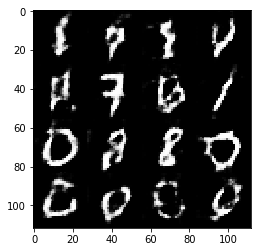

Epoch 2/2 Step 1630/1874: Discriminator Loss: 0.6389. Generator Loss: 1.1396
Epoch 2/2 Step 1640/1874: Discriminator Loss: 1.0314. Generator Loss: 1.0401
Epoch 2/2 Step 1650/1874: Discriminator Loss: 0.6329. Generator Loss: 1.2439


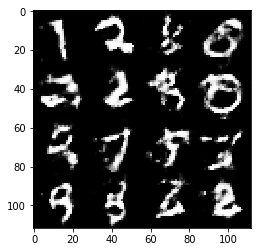

Epoch 2/2 Step 1660/1874: Discriminator Loss: 1.0765. Generator Loss: 1.0853
Epoch 2/2 Step 1670/1874: Discriminator Loss: 0.7170. Generator Loss: 1.1197
Epoch 2/2 Step 1680/1874: Discriminator Loss: 0.6575. Generator Loss: 1.1243


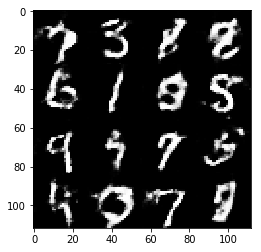

Epoch 2/2 Step 1690/1874: Discriminator Loss: 0.8557. Generator Loss: 0.9860
Epoch 2/2 Step 1700/1874: Discriminator Loss: 0.6498. Generator Loss: 1.0944
Epoch 2/2 Step 1710/1874: Discriminator Loss: 1.1324. Generator Loss: 1.2148


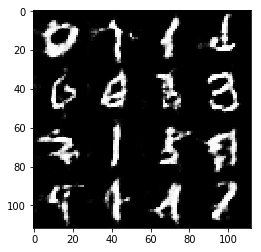

Epoch 2/2 Step 1720/1874: Discriminator Loss: 1.1121. Generator Loss: 0.7902
Epoch 2/2 Step 1730/1874: Discriminator Loss: 0.6911. Generator Loss: 1.0911
Epoch 2/2 Step 1740/1874: Discriminator Loss: 1.0618. Generator Loss: 1.2430


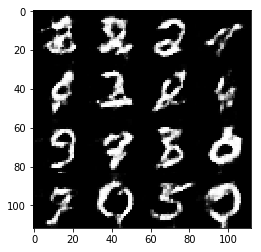

Epoch 2/2 Step 1750/1874: Discriminator Loss: 0.7638. Generator Loss: 0.9206
Epoch 2/2 Step 1760/1874: Discriminator Loss: 0.7683. Generator Loss: 1.1389
Epoch 2/2 Step 1770/1874: Discriminator Loss: 0.7628. Generator Loss: 1.4588


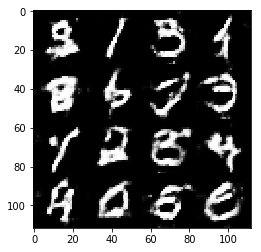

Epoch 2/2 Step 1780/1874: Discriminator Loss: 1.0836. Generator Loss: 0.9444
Epoch 2/2 Step 1790/1874: Discriminator Loss: 0.7554. Generator Loss: 1.0980
Epoch 2/2 Step 1800/1874: Discriminator Loss: 0.6547. Generator Loss: 1.0624


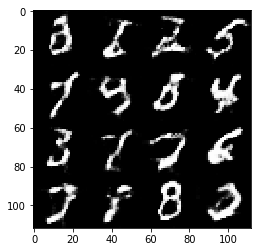

Epoch 2/2 Step 1810/1874: Discriminator Loss: 0.9666. Generator Loss: 0.8407
Epoch 2/2 Step 1820/1874: Discriminator Loss: 0.9079. Generator Loss: 1.0926
Epoch 2/2 Step 1830/1874: Discriminator Loss: 0.7919. Generator Loss: 0.9513


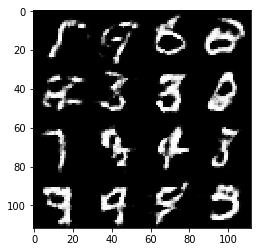

Epoch 2/2 Step 1840/1874: Discriminator Loss: 0.6332. Generator Loss: 1.1462
Epoch 2/2 Step 1850/1874: Discriminator Loss: 0.7565. Generator Loss: 1.0170
Epoch 2/2 Step 1860/1874: Discriminator Loss: 0.8231. Generator Loss: 1.0166


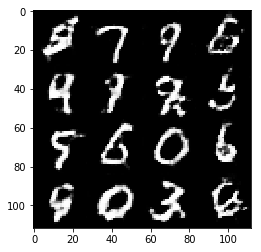

Epoch 2/2 Step 1870/1874: Discriminator Loss: 1.1936. Generator Loss: 0.9187


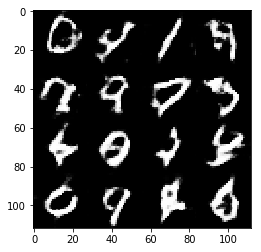

In [29]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

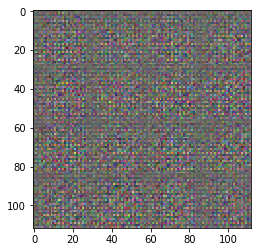

Epoch 1/1 Step 20/6331: Discriminator Loss: 1.3981. Generator Loss: 0.7223
Epoch 1/1 Step 40/6331: Discriminator Loss: 1.3737. Generator Loss: 0.7061
Epoch 1/1 Step 60/6331: Discriminator Loss: 1.3169. Generator Loss: 0.9022
Epoch 1/1 Step 80/6331: Discriminator Loss: 1.3068. Generator Loss: 0.7813
Epoch 1/1 Step 100/6331: Discriminator Loss: 1.0982. Generator Loss: 0.8623


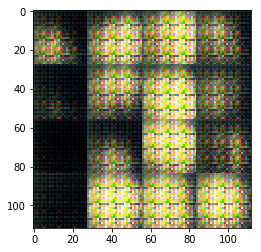

Epoch 1/1 Step 120/6331: Discriminator Loss: 1.3437. Generator Loss: 0.7570
Epoch 1/1 Step 140/6331: Discriminator Loss: 1.0793. Generator Loss: 0.8552
Epoch 1/1 Step 160/6331: Discriminator Loss: 1.3220. Generator Loss: 0.8913
Epoch 1/1 Step 180/6331: Discriminator Loss: 1.2942. Generator Loss: 0.8464
Epoch 1/1 Step 200/6331: Discriminator Loss: 1.3952. Generator Loss: 0.7357


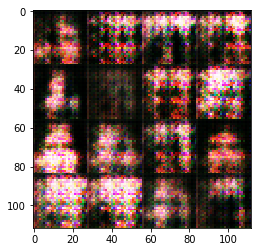

Epoch 1/1 Step 220/6331: Discriminator Loss: 1.3159. Generator Loss: 0.7347
Epoch 1/1 Step 240/6331: Discriminator Loss: 1.1912. Generator Loss: 0.7960
Epoch 1/1 Step 260/6331: Discriminator Loss: 1.4083. Generator Loss: 0.7228
Epoch 1/1 Step 280/6331: Discriminator Loss: 0.9800. Generator Loss: 0.9708
Epoch 1/1 Step 300/6331: Discriminator Loss: 1.2747. Generator Loss: 0.7516


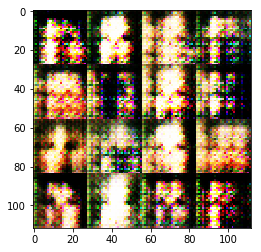

Epoch 1/1 Step 320/6331: Discriminator Loss: 1.0945. Generator Loss: 1.0472
Epoch 1/1 Step 340/6331: Discriminator Loss: 1.3315. Generator Loss: 0.6562
Epoch 1/1 Step 360/6331: Discriminator Loss: 1.3349. Generator Loss: 1.0845
Epoch 1/1 Step 380/6331: Discriminator Loss: 1.2230. Generator Loss: 0.7757
Epoch 1/1 Step 400/6331: Discriminator Loss: 0.9059. Generator Loss: 1.0516


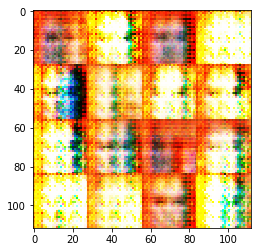

Epoch 1/1 Step 420/6331: Discriminator Loss: 1.0036. Generator Loss: 0.9375
Epoch 1/1 Step 440/6331: Discriminator Loss: 0.9896. Generator Loss: 1.0222
Epoch 1/1 Step 460/6331: Discriminator Loss: 0.9582. Generator Loss: 0.8868
Epoch 1/1 Step 480/6331: Discriminator Loss: 1.2381. Generator Loss: 1.2185
Epoch 1/1 Step 500/6331: Discriminator Loss: 1.7226. Generator Loss: 0.4866


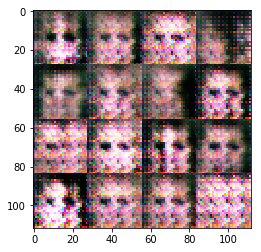

Epoch 1/1 Step 520/6331: Discriminator Loss: 1.0311. Generator Loss: 0.8174
Epoch 1/1 Step 540/6331: Discriminator Loss: 1.3596. Generator Loss: 0.5399
Epoch 1/1 Step 560/6331: Discriminator Loss: 1.3415. Generator Loss: 0.8190
Epoch 1/1 Step 580/6331: Discriminator Loss: 0.9666. Generator Loss: 1.0944
Epoch 1/1 Step 600/6331: Discriminator Loss: 1.4815. Generator Loss: 0.6373


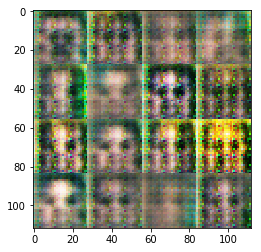

Epoch 1/1 Step 620/6331: Discriminator Loss: 1.1838. Generator Loss: 0.7186
Epoch 1/1 Step 640/6331: Discriminator Loss: 1.1496. Generator Loss: 0.6443
Epoch 1/1 Step 660/6331: Discriminator Loss: 1.2354. Generator Loss: 0.6350
Epoch 1/1 Step 680/6331: Discriminator Loss: 1.1238. Generator Loss: 0.8720
Epoch 1/1 Step 700/6331: Discriminator Loss: 1.2600. Generator Loss: 0.6696


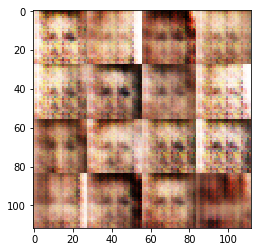

Epoch 1/1 Step 720/6331: Discriminator Loss: 1.5271. Generator Loss: 0.6031
Epoch 1/1 Step 740/6331: Discriminator Loss: 1.3429. Generator Loss: 0.6142
Epoch 1/1 Step 760/6331: Discriminator Loss: 1.5351. Generator Loss: 0.6541
Epoch 1/1 Step 780/6331: Discriminator Loss: 1.4715. Generator Loss: 0.6551
Epoch 1/1 Step 800/6331: Discriminator Loss: 1.4043. Generator Loss: 0.6927


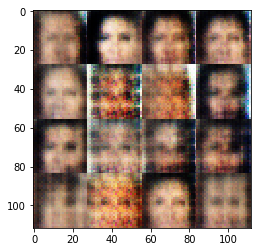

Epoch 1/1 Step 820/6331: Discriminator Loss: 1.3273. Generator Loss: 0.7108
Epoch 1/1 Step 840/6331: Discriminator Loss: 1.4479. Generator Loss: 0.6193
Epoch 1/1 Step 860/6331: Discriminator Loss: 1.3235. Generator Loss: 0.5799
Epoch 1/1 Step 880/6331: Discriminator Loss: 1.4168. Generator Loss: 0.5939
Epoch 1/1 Step 900/6331: Discriminator Loss: 1.3865. Generator Loss: 0.5966


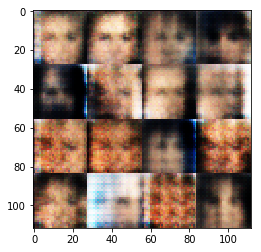

Epoch 1/1 Step 920/6331: Discriminator Loss: 1.2532. Generator Loss: 0.6046
Epoch 1/1 Step 940/6331: Discriminator Loss: 1.2518. Generator Loss: 0.6616
Epoch 1/1 Step 960/6331: Discriminator Loss: 1.2034. Generator Loss: 0.7959
Epoch 1/1 Step 980/6331: Discriminator Loss: 1.3946. Generator Loss: 0.6284
Epoch 1/1 Step 1000/6331: Discriminator Loss: 1.3248. Generator Loss: 0.6437


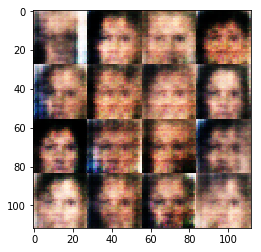

Epoch 1/1 Step 1020/6331: Discriminator Loss: 1.2184. Generator Loss: 0.8154
Epoch 1/1 Step 1040/6331: Discriminator Loss: 1.6750. Generator Loss: 0.4639
Epoch 1/1 Step 1060/6331: Discriminator Loss: 1.2433. Generator Loss: 0.5564
Epoch 1/1 Step 1080/6331: Discriminator Loss: 1.3416. Generator Loss: 0.8086
Epoch 1/1 Step 1100/6331: Discriminator Loss: 1.3310. Generator Loss: 0.7058


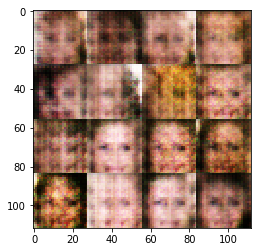

Epoch 1/1 Step 1120/6331: Discriminator Loss: 1.3339. Generator Loss: 0.6370
Epoch 1/1 Step 1140/6331: Discriminator Loss: 1.1815. Generator Loss: 0.8265
Epoch 1/1 Step 1160/6331: Discriminator Loss: 1.3011. Generator Loss: 0.6771
Epoch 1/1 Step 1180/6331: Discriminator Loss: 1.0921. Generator Loss: 0.7090
Epoch 1/1 Step 1200/6331: Discriminator Loss: 1.3107. Generator Loss: 0.5826


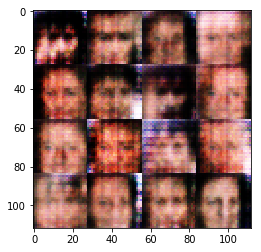

Epoch 1/1 Step 1220/6331: Discriminator Loss: 1.0885. Generator Loss: 0.9731
Epoch 1/1 Step 1240/6331: Discriminator Loss: 1.2655. Generator Loss: 0.6592
Epoch 1/1 Step 1260/6331: Discriminator Loss: 1.3644. Generator Loss: 0.7805
Epoch 1/1 Step 1280/6331: Discriminator Loss: 1.1813. Generator Loss: 0.6780
Epoch 1/1 Step 1300/6331: Discriminator Loss: 1.5824. Generator Loss: 0.7245


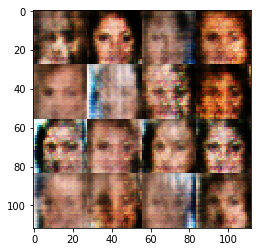

Epoch 1/1 Step 1320/6331: Discriminator Loss: 1.3416. Generator Loss: 0.5745
Epoch 1/1 Step 1340/6331: Discriminator Loss: 1.3259. Generator Loss: 0.7534
Epoch 1/1 Step 1360/6331: Discriminator Loss: 1.2814. Generator Loss: 0.7697
Epoch 1/1 Step 1380/6331: Discriminator Loss: 1.4087. Generator Loss: 0.6159
Epoch 1/1 Step 1400/6331: Discriminator Loss: 1.2663. Generator Loss: 0.7258


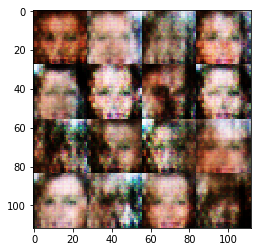

Epoch 1/1 Step 1420/6331: Discriminator Loss: 1.3785. Generator Loss: 0.6859
Epoch 1/1 Step 1440/6331: Discriminator Loss: 1.2592. Generator Loss: 0.7006
Epoch 1/1 Step 1460/6331: Discriminator Loss: 1.0368. Generator Loss: 0.7895
Epoch 1/1 Step 1480/6331: Discriminator Loss: 1.2004. Generator Loss: 0.6461
Epoch 1/1 Step 1500/6331: Discriminator Loss: 1.3028. Generator Loss: 0.6933


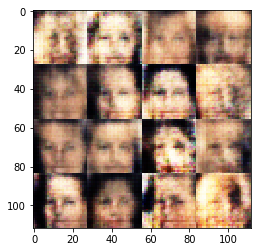

Epoch 1/1 Step 1520/6331: Discriminator Loss: 1.5174. Generator Loss: 0.6327
Epoch 1/1 Step 1540/6331: Discriminator Loss: 1.2032. Generator Loss: 0.6453
Epoch 1/1 Step 1560/6331: Discriminator Loss: 1.1632. Generator Loss: 0.8845
Epoch 1/1 Step 1580/6331: Discriminator Loss: 1.3912. Generator Loss: 0.5410
Epoch 1/1 Step 1600/6331: Discriminator Loss: 1.0736. Generator Loss: 0.9628


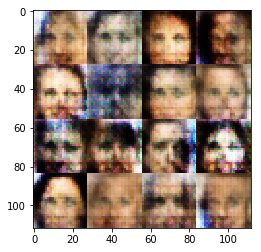

Epoch 1/1 Step 1620/6331: Discriminator Loss: 1.5631. Generator Loss: 0.7294
Epoch 1/1 Step 1640/6331: Discriminator Loss: 1.1521. Generator Loss: 0.6403
Epoch 1/1 Step 1660/6331: Discriminator Loss: 1.5190. Generator Loss: 0.7980
Epoch 1/1 Step 1680/6331: Discriminator Loss: 1.5084. Generator Loss: 0.6455
Epoch 1/1 Step 1700/6331: Discriminator Loss: 1.4023. Generator Loss: 0.6563


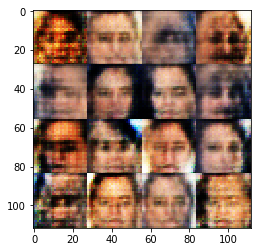

Epoch 1/1 Step 1720/6331: Discriminator Loss: 1.4442. Generator Loss: 0.5767
Epoch 1/1 Step 1740/6331: Discriminator Loss: 1.1278. Generator Loss: 0.8724
Epoch 1/1 Step 1760/6331: Discriminator Loss: 1.1083. Generator Loss: 0.7616
Epoch 1/1 Step 1780/6331: Discriminator Loss: 1.2697. Generator Loss: 0.6548
Epoch 1/1 Step 1800/6331: Discriminator Loss: 1.0090. Generator Loss: 0.8169


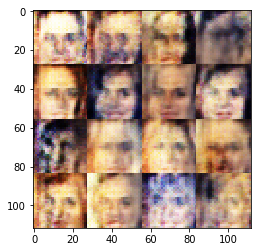

Epoch 1/1 Step 1820/6331: Discriminator Loss: 0.9064. Generator Loss: 0.8823
Epoch 1/1 Step 1840/6331: Discriminator Loss: 1.3324. Generator Loss: 0.4866
Epoch 1/1 Step 1860/6331: Discriminator Loss: 1.1900. Generator Loss: 0.6741
Epoch 1/1 Step 1880/6331: Discriminator Loss: 1.4397. Generator Loss: 1.0898
Epoch 1/1 Step 1900/6331: Discriminator Loss: 0.8895. Generator Loss: 0.7517


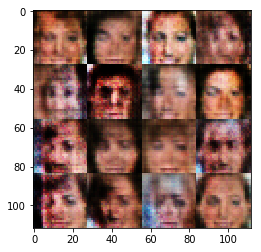

Epoch 1/1 Step 1920/6331: Discriminator Loss: 1.3405. Generator Loss: 0.4868
Epoch 1/1 Step 1940/6331: Discriminator Loss: 1.0177. Generator Loss: 0.7649
Epoch 1/1 Step 1960/6331: Discriminator Loss: 0.7096. Generator Loss: 1.0401
Epoch 1/1 Step 1980/6331: Discriminator Loss: 1.2020. Generator Loss: 1.1732
Epoch 1/1 Step 2000/6331: Discriminator Loss: 1.1716. Generator Loss: 1.2498


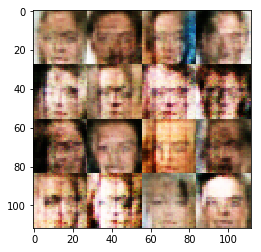

Epoch 1/1 Step 2020/6331: Discriminator Loss: 1.0591. Generator Loss: 0.8400
Epoch 1/1 Step 2040/6331: Discriminator Loss: 0.9857. Generator Loss: 0.7855
Epoch 1/1 Step 2060/6331: Discriminator Loss: 1.0096. Generator Loss: 0.8693
Epoch 1/1 Step 2080/6331: Discriminator Loss: 1.4788. Generator Loss: 0.7107
Epoch 1/1 Step 2100/6331: Discriminator Loss: 0.7906. Generator Loss: 1.1382


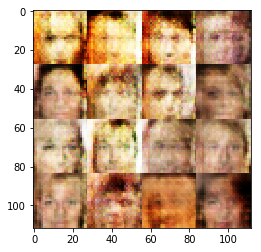

Epoch 1/1 Step 2120/6331: Discriminator Loss: 1.1248. Generator Loss: 0.6792
Epoch 1/1 Step 2140/6331: Discriminator Loss: 0.5388. Generator Loss: 1.4335
Epoch 1/1 Step 2160/6331: Discriminator Loss: 1.5892. Generator Loss: 0.3522
Epoch 1/1 Step 2180/6331: Discriminator Loss: 0.9351. Generator Loss: 1.1960
Epoch 1/1 Step 2200/6331: Discriminator Loss: 0.9964. Generator Loss: 0.6512


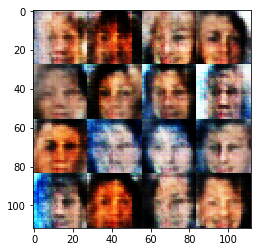

Epoch 1/1 Step 2220/6331: Discriminator Loss: 1.0200. Generator Loss: 0.6724
Epoch 1/1 Step 2240/6331: Discriminator Loss: 0.8216. Generator Loss: 0.9980
Epoch 1/1 Step 2260/6331: Discriminator Loss: 0.7094. Generator Loss: 1.7837
Epoch 1/1 Step 2280/6331: Discriminator Loss: 0.5269. Generator Loss: 1.5584
Epoch 1/1 Step 2300/6331: Discriminator Loss: 0.3862. Generator Loss: 1.8010


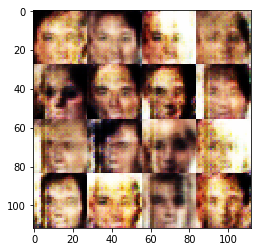

Epoch 1/1 Step 2320/6331: Discriminator Loss: 1.4968. Generator Loss: 0.5737
Epoch 1/1 Step 2340/6331: Discriminator Loss: 1.8287. Generator Loss: 0.4205
Epoch 1/1 Step 2360/6331: Discriminator Loss: 1.4548. Generator Loss: 1.2070
Epoch 1/1 Step 2380/6331: Discriminator Loss: 1.2871. Generator Loss: 1.6185
Epoch 1/1 Step 2400/6331: Discriminator Loss: 0.6511. Generator Loss: 1.4992


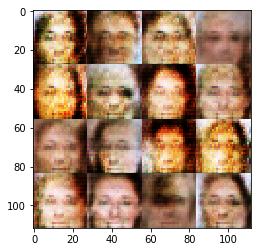

Epoch 1/1 Step 2420/6331: Discriminator Loss: 0.5408. Generator Loss: 1.3189
Epoch 1/1 Step 2440/6331: Discriminator Loss: 0.6078. Generator Loss: 1.5478
Epoch 1/1 Step 2460/6331: Discriminator Loss: 1.5623. Generator Loss: 0.4680
Epoch 1/1 Step 2480/6331: Discriminator Loss: 1.6492. Generator Loss: 0.3485
Epoch 1/1 Step 2500/6331: Discriminator Loss: 0.3856. Generator Loss: 1.7530


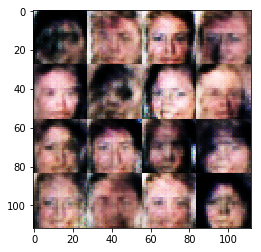

Epoch 1/1 Step 2520/6331: Discriminator Loss: 0.6456. Generator Loss: 1.1201
Epoch 1/1 Step 2540/6331: Discriminator Loss: 1.0198. Generator Loss: 0.7626
Epoch 1/1 Step 2560/6331: Discriminator Loss: 1.4217. Generator Loss: 0.4855
Epoch 1/1 Step 2580/6331: Discriminator Loss: 0.6930. Generator Loss: 0.9532
Epoch 1/1 Step 2600/6331: Discriminator Loss: 0.5359. Generator Loss: 1.1260


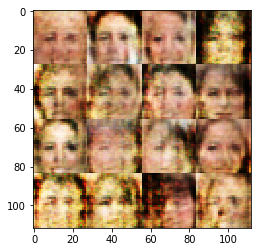

Epoch 1/1 Step 2620/6331: Discriminator Loss: 0.4894. Generator Loss: 1.2748
Epoch 1/1 Step 2640/6331: Discriminator Loss: 1.3369. Generator Loss: 0.8827
Epoch 1/1 Step 2660/6331: Discriminator Loss: 1.3257. Generator Loss: 0.6985
Epoch 1/1 Step 2680/6331: Discriminator Loss: 1.3620. Generator Loss: 1.1339
Epoch 1/1 Step 2700/6331: Discriminator Loss: 1.0838. Generator Loss: 1.3835


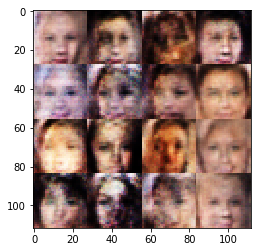

Epoch 1/1 Step 2720/6331: Discriminator Loss: 0.8237. Generator Loss: 0.9013
Epoch 1/1 Step 2740/6331: Discriminator Loss: 0.6956. Generator Loss: 0.9844
Epoch 1/1 Step 2760/6331: Discriminator Loss: 0.5967. Generator Loss: 1.1950
Epoch 1/1 Step 2780/6331: Discriminator Loss: 0.4110. Generator Loss: 1.3939
Epoch 1/1 Step 2800/6331: Discriminator Loss: 0.3911. Generator Loss: 1.7639


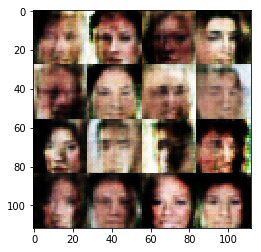

Epoch 1/1 Step 2820/6331: Discriminator Loss: 0.9624. Generator Loss: 0.8679
Epoch 1/1 Step 2840/6331: Discriminator Loss: 1.2481. Generator Loss: 0.6598
Epoch 1/1 Step 2860/6331: Discriminator Loss: 0.3440. Generator Loss: 1.7927
Epoch 1/1 Step 2880/6331: Discriminator Loss: 0.4976. Generator Loss: 1.1947
Epoch 1/1 Step 2900/6331: Discriminator Loss: 0.2646. Generator Loss: 1.8840


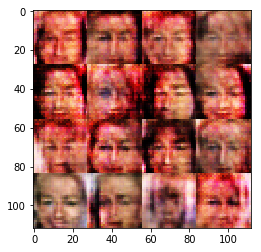

Epoch 1/1 Step 2920/6331: Discriminator Loss: 0.2468. Generator Loss: 1.9368
Epoch 1/1 Step 2940/6331: Discriminator Loss: 0.5910. Generator Loss: 2.0904
Epoch 1/1 Step 2960/6331: Discriminator Loss: 0.1202. Generator Loss: 2.8033
Epoch 1/1 Step 2980/6331: Discriminator Loss: 0.1589. Generator Loss: 2.4929
Epoch 1/1 Step 3000/6331: Discriminator Loss: 0.4038. Generator Loss: 2.1221


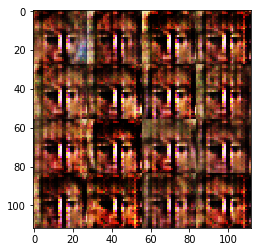

Epoch 1/1 Step 3020/6331: Discriminator Loss: 0.3209. Generator Loss: 2.4709
Epoch 1/1 Step 3040/6331: Discriminator Loss: 0.2952. Generator Loss: 2.9732
Epoch 1/1 Step 3060/6331: Discriminator Loss: 0.2015. Generator Loss: 2.7197
Epoch 1/1 Step 3080/6331: Discriminator Loss: 0.1469. Generator Loss: 3.0721
Epoch 1/1 Step 3100/6331: Discriminator Loss: 0.1689. Generator Loss: 2.6858


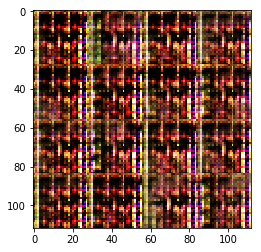

Epoch 1/1 Step 3120/6331: Discriminator Loss: 0.1360. Generator Loss: 2.8501
Epoch 1/1 Step 3140/6331: Discriminator Loss: 0.1028. Generator Loss: 3.5363
Epoch 1/1 Step 3160/6331: Discriminator Loss: 0.0878. Generator Loss: 3.4532
Epoch 1/1 Step 3180/6331: Discriminator Loss: 0.2206. Generator Loss: 1.7712
Epoch 1/1 Step 3200/6331: Discriminator Loss: 0.1088. Generator Loss: 2.6639


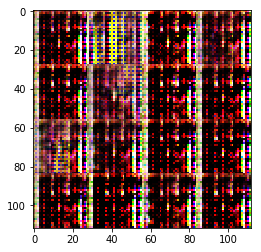

Epoch 1/1 Step 3220/6331: Discriminator Loss: 0.1410. Generator Loss: 2.3793
Epoch 1/1 Step 3240/6331: Discriminator Loss: 0.1319. Generator Loss: 2.4936
Epoch 1/1 Step 3260/6331: Discriminator Loss: 1.2270. Generator Loss: 2.7450
Epoch 1/1 Step 3280/6331: Discriminator Loss: 0.1406. Generator Loss: 2.8997
Epoch 1/1 Step 3300/6331: Discriminator Loss: 0.0877. Generator Loss: 3.1267


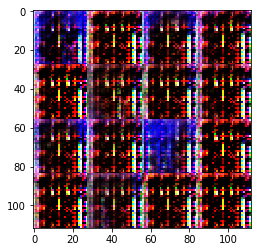

Epoch 1/1 Step 3320/6331: Discriminator Loss: 0.0852. Generator Loss: 3.5179
Epoch 1/1 Step 3340/6331: Discriminator Loss: 0.0458. Generator Loss: 3.5335
Epoch 1/1 Step 3360/6331: Discriminator Loss: 0.0647. Generator Loss: 3.7015
Epoch 1/1 Step 3380/6331: Discriminator Loss: 0.0424. Generator Loss: 3.6343
Epoch 1/1 Step 3400/6331: Discriminator Loss: 0.1931. Generator Loss: 3.0037


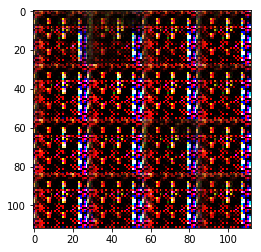

Epoch 1/1 Step 3420/6331: Discriminator Loss: 0.1615. Generator Loss: 3.4702
Epoch 1/1 Step 3440/6331: Discriminator Loss: 0.0807. Generator Loss: 3.9223
Epoch 1/1 Step 3460/6331: Discriminator Loss: 0.2645. Generator Loss: 3.3346
Epoch 1/1 Step 3480/6331: Discriminator Loss: 0.0829. Generator Loss: 3.0548
Epoch 1/1 Step 3500/6331: Discriminator Loss: 0.0642. Generator Loss: 3.1246


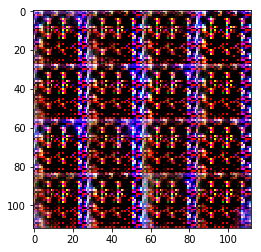

Epoch 1/1 Step 3520/6331: Discriminator Loss: 0.0760. Generator Loss: 2.9225
Epoch 1/1 Step 3540/6331: Discriminator Loss: 0.0443. Generator Loss: 3.4098
Epoch 1/1 Step 3560/6331: Discriminator Loss: 0.0497. Generator Loss: 3.5863
Epoch 1/1 Step 3580/6331: Discriminator Loss: 0.0772. Generator Loss: 3.6870
Epoch 1/1 Step 3600/6331: Discriminator Loss: 0.1174. Generator Loss: 3.3295


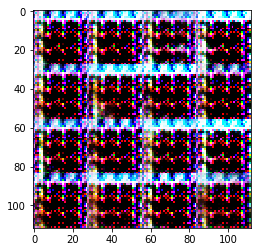

Epoch 1/1 Step 3620/6331: Discriminator Loss: 0.0965. Generator Loss: 4.5713
Epoch 1/1 Step 3640/6331: Discriminator Loss: 0.0316. Generator Loss: 4.5923
Epoch 1/1 Step 3660/6331: Discriminator Loss: 0.0564. Generator Loss: 3.7518
Epoch 1/1 Step 3680/6331: Discriminator Loss: 0.0317. Generator Loss: 4.3888
Epoch 1/1 Step 3700/6331: Discriminator Loss: 0.0237. Generator Loss: 4.3689


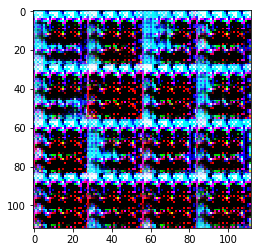

Epoch 1/1 Step 3720/6331: Discriminator Loss: 0.0489. Generator Loss: 3.9670
Epoch 1/1 Step 3740/6331: Discriminator Loss: 0.0336. Generator Loss: 4.0982
Epoch 1/1 Step 3760/6331: Discriminator Loss: 0.0322. Generator Loss: 4.0000
Epoch 1/1 Step 3780/6331: Discriminator Loss: 0.0208. Generator Loss: 4.6316
Epoch 1/1 Step 3800/6331: Discriminator Loss: 0.0211. Generator Loss: 4.6860


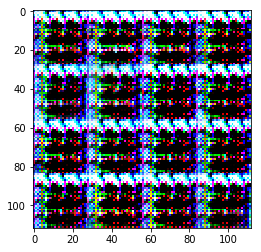

Epoch 1/1 Step 3820/6331: Discriminator Loss: 0.0198. Generator Loss: 4.4810
Epoch 1/1 Step 3840/6331: Discriminator Loss: 0.0276. Generator Loss: 4.3437
Epoch 1/1 Step 3860/6331: Discriminator Loss: 0.0323. Generator Loss: 4.5183
Epoch 1/1 Step 3880/6331: Discriminator Loss: 0.0241. Generator Loss: 4.0996
Epoch 1/1 Step 3900/6331: Discriminator Loss: 0.0689. Generator Loss: 4.1445


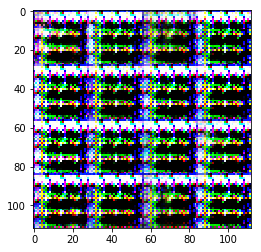

Epoch 1/1 Step 3920/6331: Discriminator Loss: 0.1793. Generator Loss: 3.2265
Epoch 1/1 Step 3940/6331: Discriminator Loss: 0.3427. Generator Loss: 3.8274
Epoch 1/1 Step 3960/6331: Discriminator Loss: 0.0559. Generator Loss: 4.9844
Epoch 1/1 Step 3980/6331: Discriminator Loss: 0.0490. Generator Loss: 5.1854
Epoch 1/1 Step 4000/6331: Discriminator Loss: 0.0514. Generator Loss: 3.7569


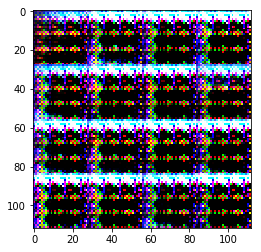

Epoch 1/1 Step 4020/6331: Discriminator Loss: 0.0407. Generator Loss: 4.1336
Epoch 1/1 Step 4040/6331: Discriminator Loss: 0.0287. Generator Loss: 4.7136
Epoch 1/1 Step 4060/6331: Discriminator Loss: 0.0409. Generator Loss: 4.1906
Epoch 1/1 Step 4080/6331: Discriminator Loss: 0.0343. Generator Loss: 4.4063
Epoch 1/1 Step 4100/6331: Discriminator Loss: 0.0385. Generator Loss: 4.1396


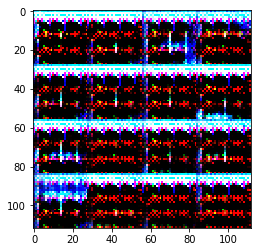

Epoch 1/1 Step 4120/6331: Discriminator Loss: 0.0409. Generator Loss: 3.9099
Epoch 1/1 Step 4140/6331: Discriminator Loss: 0.0284. Generator Loss: 4.2726
Epoch 1/1 Step 4160/6331: Discriminator Loss: 0.0456. Generator Loss: 4.1066
Epoch 1/1 Step 4180/6331: Discriminator Loss: 0.0484. Generator Loss: 4.3316
Epoch 1/1 Step 4200/6331: Discriminator Loss: 0.0305. Generator Loss: 4.5750


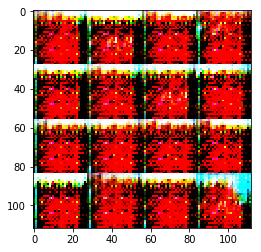

Epoch 1/1 Step 4220/6331: Discriminator Loss: 0.0339. Generator Loss: 4.6790
Epoch 1/1 Step 4240/6331: Discriminator Loss: 0.0466. Generator Loss: 3.7480
Epoch 1/1 Step 4260/6331: Discriminator Loss: 0.0282. Generator Loss: 4.3534
Epoch 1/1 Step 4280/6331: Discriminator Loss: 0.0321. Generator Loss: 4.4831
Epoch 1/1 Step 4300/6331: Discriminator Loss: 0.1823. Generator Loss: 2.7194


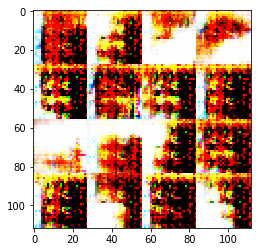

Epoch 1/1 Step 4320/6331: Discriminator Loss: 1.6101. Generator Loss: 1.8950
Epoch 1/1 Step 4340/6331: Discriminator Loss: 1.7472. Generator Loss: 1.3942
Epoch 1/1 Step 4360/6331: Discriminator Loss: 0.1619. Generator Loss: 2.8063
Epoch 1/1 Step 4380/6331: Discriminator Loss: 0.1131. Generator Loss: 2.8651
Epoch 1/1 Step 4400/6331: Discriminator Loss: 0.0469. Generator Loss: 3.4425


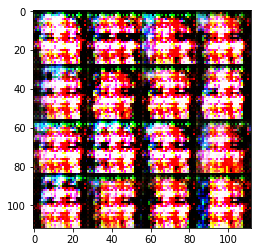

Epoch 1/1 Step 4420/6331: Discriminator Loss: 0.1239. Generator Loss: 3.7761
Epoch 1/1 Step 4440/6331: Discriminator Loss: 0.0536. Generator Loss: 5.0349
Epoch 1/1 Step 4460/6331: Discriminator Loss: 0.3866. Generator Loss: 4.0503
Epoch 1/1 Step 4480/6331: Discriminator Loss: 0.0422. Generator Loss: 4.2405
Epoch 1/1 Step 4500/6331: Discriminator Loss: 0.0432. Generator Loss: 4.1329


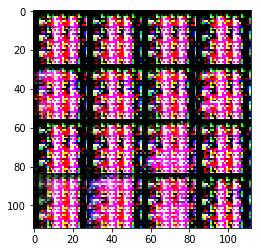

Epoch 1/1 Step 4520/6331: Discriminator Loss: 1.4758. Generator Loss: 4.0731
Epoch 1/1 Step 4540/6331: Discriminator Loss: 0.0259. Generator Loss: 4.1540
Epoch 1/1 Step 4560/6331: Discriminator Loss: 0.0451. Generator Loss: 3.7699
Epoch 1/1 Step 4580/6331: Discriminator Loss: 0.0281. Generator Loss: 3.7533
Epoch 1/1 Step 4600/6331: Discriminator Loss: 0.0222. Generator Loss: 4.2032


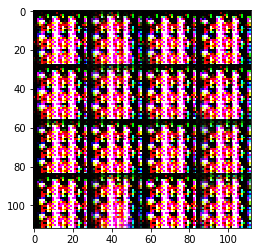

Epoch 1/1 Step 4620/6331: Discriminator Loss: 0.0345. Generator Loss: 4.0043
Epoch 1/1 Step 4640/6331: Discriminator Loss: 0.0317. Generator Loss: 4.1647
Epoch 1/1 Step 4660/6331: Discriminator Loss: 0.0271. Generator Loss: 4.2852
Epoch 1/1 Step 4680/6331: Discriminator Loss: 0.0251. Generator Loss: 4.6279
Epoch 1/1 Step 4700/6331: Discriminator Loss: 0.0233. Generator Loss: 4.5691


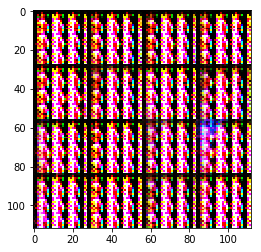

Epoch 1/1 Step 4720/6331: Discriminator Loss: 0.0179. Generator Loss: 4.4848
Epoch 1/1 Step 4740/6331: Discriminator Loss: 0.0200. Generator Loss: 4.5600


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.2

learning_rate = 0.0015
beta1 = 0.1

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

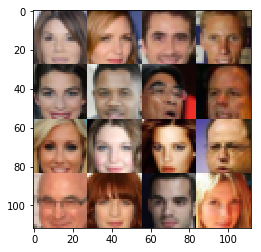

In [41]:
# Original images for comparison
orig_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:16], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(orig_images, 'RGB'))

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.